In [54]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from mlxtend.evaluate import permutation_test

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

In [13]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

In [14]:
# predictions
multicener_predictions = np.genfromtxt('../res/multi-center/nested_cv_pred_full_GroupKFold30.csv', delimiter=',')
rpn_predictions = np.hstack((df_bochum.nested_prediction,
                            df_essen.prediction,
                            df_szeged.prediction))

predictions = {
    'single-center' : rpn_predictions,
    'multi-center' : multicener_predictions
}

In [15]:
study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values,
    "study 1+2+3" : np.array([True] * len(y))
}

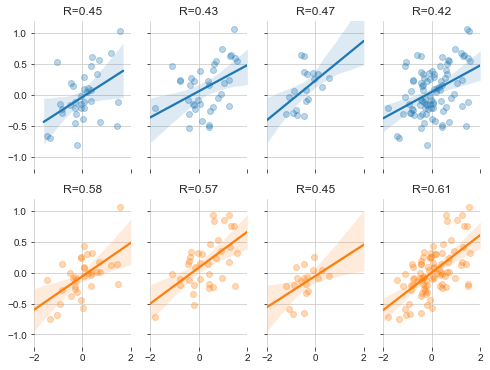

In [57]:
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8,6), sharex=True, sharey=True)

cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(predictions.keys()):
    for col, study in enumerate(study_masks.keys()):
        g=sns.regplot(y[study_masks[study]], predictions[cv][study_masks[study]], ax=axs[row, col],
                    scatter=True, scatter_kws={'alpha':0.3}, color=cols[row])
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-1.2, 1.2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].grid(True)
         
        # uncomment what you need:    
            
        corr = np.corrcoef(y[study_masks[study]], predictions[cv][study_masks[study]])[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        
        # be patient with this
        #p_corr = permutation_test(y[study_masks[study]], predictions[cv][study_masks[study]],
        #                   func=lambda x, y: np.corrcoef(x, y)[0,1],
        #                   method='approximate',
        #                   num_rounds=10000,
        #                   seed=42)
        #axs[row, col].title.set_text("p_corr={:.5f}".format(p_corr))
        
        #mse = mean_squared_error(y[study_masks[study]], predictions[cv][study_masks[study]])
        #axs[row, col].title.set_text("MSE={:.2f}".format(mse))
        
        #mae = mean_absolute_error(y[study_masks[study]], predictions[cv][study_masks[study]])
        #axs[row, col].title.set_text("MSE={:.2f}".format(mae))
        
        #expvar = explained_variance_score(y[study_masks[study]], predictions[cv][study_masks[study]])
        #axs[row, col].title.set_text("Expl. Var. ={:.3f}".format(expvar))
   
   
        
plt.savefig('../res/multi-center/regplots_obs-pred.pdf')  